In [1]:
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(formattable)
library(IRdisplay) # displays tables when in ipynb format

library(xgboost)
library(tidymodels)
#library(SHAPforxgboost)


source("./Baudry_functions_v2.R")


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp


-- Attaching packages ------------------------------------------------------------------------------ tidymodels 1.1.0 --

v broom        1.0.5     v rsample      1.1.1
v dials        1.2.0     v tibble       3.2.1
v dplyr        1.1.4     v tidyr        1.3.1
v infer        1.0.4     v tune         1.1.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.1.0     v workflowsets 1.0.1
v purrr        1.0.2     v yardstick    1.3.1
v recipes      1.0.6     

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x dplyr::between()    masks data

In [2]:
dt_PhoneData <- simulate_central_scenario(1234)


In [3]:


dt_polclaim <- join_policy_claim(dt_PhoneData,
                                 date_pol_start = "date_UW",
                                 date_pol_end = "date_lapse",
                                 date_occur = "date_occur")


In [4]:

lst_Date_slice <- floor_date(seq(as.Date("2016/1/1"), as.Date("2019/06/30"), by = 30), unit= "second") 
dt_polclaim <- time_slice_polclaim(dt_polclaim, lst_Date_slice)

In [5]:


i <- valuation <- 10
t_i <- lst_Date_slice[i] 
delta <- min(i, length(lst_Date_slice) - i + 1)


In [6]:
#define modelVars
RBNS_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     "target"
    )


# Create a combined TRAIN dataset for k = 1 and all valid j delay values
dt_RBNS_train <- RBNS_Train(dt_polclaim, t_i, i, k = 1, lst_Date_slice, RBNS_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_RBNS_test <- RBNS_Test(dt_polclaim, t_i, delta, k = 1, lst_Date_slice, RBNS_model_vars)

In [7]:


# Add a flag to determine which rows are from the trainset and which from the test set
dt_RBNS_train[, flgTrain := 1]
dt_RBNS_test[, flgTrain := 0]

# combine into a single RBNS dataset   
dt_All_RBNS <- rbind(dt_RBNS_train, dt_RBNS_test)
#write.csv(dt_All_RBNS,"dt_All_RBNS.csv", row.names = F)


In [8]:
# tidy up
rm(dt_RBNS_train)
rm(dt_RBNS_test)
gc()
    

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2916624,155.8,6496091,347.0,4506342,240.7
Vcells,40875694,311.9,62308390,475.4,51847458,395.6


In [9]:
# order and create some delay fields
setkey(dt_All_RBNS, clm_number, k, j)
    
dt_All_RBNS[, Count := .N , by =clm_number]

#create delay measures and convert time measures from intervals of seconds to intervals of days
dt_All_RBNS[, ':='(
  delay_uw_occ = ifelse(year(date_occur) == 2199,
                        -1,
                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start)) / (24 * 60 * 60))
                        ),
  delay_occ_rep = ifelse(year(date_occur) == 2199,
                         -1,
                         ceiling((as.numeric(date_report) - as.numeric(date_occur)) / (24 * 60 * 60))
                         ),
  delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start)) / (24 * 60 * 60)),
  delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
  
  date_uw = ceiling(as.numeric(date_pol_start) / (24 *  60 * 60)),
  Cover = as.factor(Cover),
  claim_type = as.factor(claim_type)
  )]
  

In [10]:
#define IBNR modelVars
IBNR_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "exposure",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "target")
    
# Create a combined TRAIN dataset for k = 1 and all valid j delay values
lst_IBNR_train <- IBNR_Train(dt_polclaim, t_i, i, k = 1,lst_Date_slice, IBNR_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_IBNR_test <- IBNR_Test(dt_polclaim, t_i, delta, k = 1,lst_Date_slice, IBNR_model_vars)

     

In [11]:

lst_IBNR_train$Freq[, flgTrain := 1]
lst_IBNR_train$Loss[, flgTrain := 2]
dt_IBNR_test[, flgTrain := 0]

dt_All_IBNR <- rbind(
  lst_IBNR_train$Freq,
  lst_IBNR_train$Loss,
  dt_IBNR_test
)

#write.csv(dt_All_IBNR,"dt_All_IBNR.csv", row.names = F)

In [12]:
# tidy up
rm(lst_IBNR_train)
rm(dt_IBNR_test)
gc()



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2924383,156.2,6496091,347.0,4506342,240.7
Vcells,75726446,577.8,155638539,1187.5,129096403,985.0


In [13]:
# order and create some delay fields
setkey(dt_All_IBNR, clm_number, k, j)
    
dt_All_IBNR[, Count := .N , by =clm_number]
dt_All_IBNR[,':='( delay_uw_occ = ifelse(year(date_occur) == 2199,
                                        -1,
                                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start))
                                                  /(24*60*60))
                                          ),
                   delay_occ_rep = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_report) - as.numeric(date_occur))
                                                  /(24*60*60))
                                          ),
                   delay_rep_pay = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_pay) - as.numeric(date_report))
                                                  /(24*60*60))
                                          ),
                   delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start))/(24*60*60)),
                   date_uw = ceiling(as.numeric(date_pol_start)/(24*60*60)),
                   Cover = as.factor(Cover))]

In [14]:
RBNS_predictors <- c("j",
                     "k",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     #"date_uw",
                     #"delay_uw_occ",
                     "delay_occ_rep")

rowList_RBNS <- list(train=dt_All_RBNS[, which(flgTrain==1)],
                test=dt_All_RBNS[, which(flgTrain==0)],
                all = 1:nrow(dt_All_RBNS))


RBNS_rec <- recipe( ~ ., data = dt_All_RBNS[, RBNS_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()


df.RBNS_train <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$train,] )
df.RBNS_test <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$test,] )
df.RBNS_all <- bake(RBNS_rec, new_data = dt_All_RBNS )


xgb.RBNS_DMat.train <- xgb.DMatrix(data = as.matrix(df.RBNS_train),
                              label = dt_All_RBNS[rowList_RBNS$train, target])

xgb.RBNS_DMat.test <- xgb.DMatrix(data = as.matrix(df.RBNS_test),
                              label = dt_All_RBNS[rowList_RBNS$test, target])

xgb.RBNS_DMat.all <- xgb.DMatrix(data = as.matrix(df.RBNS_all),
                             label = dt_All_RBNS[, target])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   76.44    0.00  913.00 

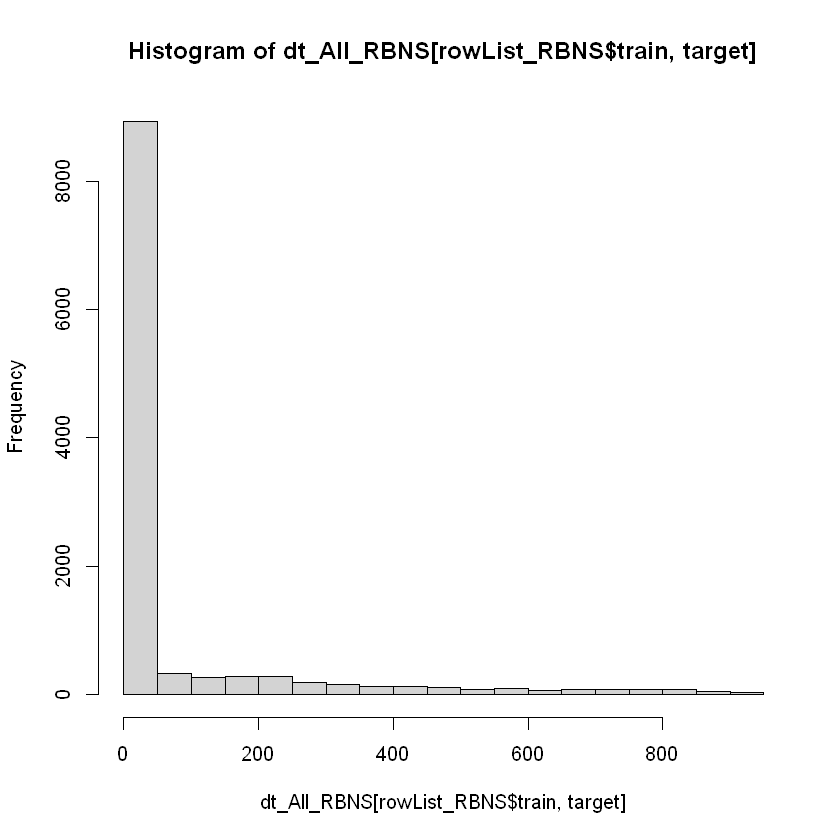

In [15]:
summary(dt_All_RBNS[rowList_RBNS$train, target])
hist(dt_All_RBNS[rowList_RBNS$train, target])

In [16]:
param <- list(
  objective = "reg:tweedie",
  max_depth = 2L,            # tree-depth
  subsample = 0.75,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,    # randomly sample columns before fitting each tree
  min.child.weight = 10,     # minimum weight per leaf
  eta = 0.1                  # Learning rate
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_RBNS_CV <- xgb.cv(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = 500,        # Maximum number of trees to build
  nfold = 5,
  early_stopping_rounds  = 10L,        # Stops algorithm early if performance has not improved in 
  print_every_n          = 10L,        # How often to print to console
  prediction             = TRUE        # Keeps the predictions
)

[1]	train-tweedie-nloglik@1.5:58.009016+0.518944	test-tweedie-nloglik@1.5:58.010415+1.320197 
Multiple eval metrics are present. Will use test_tweedie_nloglik@1.5 for early stopping.
Will train until test_tweedie_nloglik@1.5 hasn't improved in 10 rounds.

[11]	train-tweedie-nloglik@1.5:30.450703+0.768483	test-tweedie-nloglik@1.5:30.453809+0.690378 
[21]	train-tweedie-nloglik@1.5:22.203900+0.201559	test-tweedie-nloglik@1.5:22.239458+0.302289 
[31]	train-tweedie-nloglik@1.5:20.335487+0.097273	test-tweedie-nloglik@1.5:20.358262+0.348085 
[41]	train-tweedie-nloglik@1.5:19.797811+0.060289	test-tweedie-nloglik@1.5:19.824879+0.331764 
[51]	train-tweedie-nloglik@1.5:19.590436+0.067170	test-tweedie-nloglik@1.5:19.620479+0.304170 
[61]	train-tweedie-nloglik@1.5:19.496678+0.066665	test-tweedie-nloglik@1.5:19.530647+0.298147 
[71]	train-tweedie-nloglik@1.5:19.452399+0.067554	test-tweedie-nloglik@1.5:19.493740+0.296797 
[81]	train-tweedie-nloglik@1.5:19.427254+0.070937	test-tweedie-nloglik@1.5:19.4

In [17]:
dt_All_RBNS[rowList_RBNS$train, preds_oof := xgb_RBNS_CV$pred]

In [37]:
head(dt_All_RBNS)

clm_number,pol_number,j,k,date_pol_start,date_occur,date_report,date_pay,Cover,claim_type,...,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_uw_val,delay_rep_pay,date_uw,preds_oof,preds_full,date_occur_YYYYMM
<chr>,<chr>,<int>,<int>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,<fct>,...,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
201601060001,201601050343,8,1,2016-01-05,2016-01-06,2016-01-06,2016-02-08,BOT,B,...,1,1,1,0,266,33,16805,2.298989e-05,3.795441e-05,2016.01
201601080001,201601040365,8,1,2016-01-04,2016-01-08,2016-01-08,2016-02-13,BOT,B,...,1,1,4,0,267,36,16804,2.289587e-05,3.770641e-05,2016.01
201601080002,201601040629,8,1,2016-01-04,2016-01-08,2016-01-08,2016-02-07,BO,B,...,1,1,4,0,267,30,16804,3.633207e-05,3.701606e-05,2016.01
201601090001,201601010222,8,1,2016-01-01,2016-01-09,2016-01-09,2016-02-05,BOT,B,...,1,1,8,0,270,27,16801,2.677232e-05,3.795441e-05,2016.01
201601090002,201601030514,8,1,2016-01-03,2016-01-07,2016-01-09,2016-02-09,BO,O,...,1,1,4,2,268,31,16803,1.095622e-04,7.149587e-05,2016.01
201601100001,201601010095,8,1,2016-01-01,2016-01-10,2016-01-10,2016-02-06,B,B,...,1,1,9,0,270,27,16801,4.009075e-05,3.945152e-05,2016.01


In [19]:
# View only the rows that have OOF predictions (i.e., training data)
dt_All_RBNS[flgTrain == 1, .(pol_number,flgTrain,target, Price, preds_oof)]


pol_number,flgTrain,target,Price,preds_oof
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
201601050343,1,0,913,2.298989e-05
201601040365,1,0,728,2.289587e-05
201601040629,1,0,728,3.633207e-05
201601010222,1,0,913,2.677232e-05
201601030514,1,0,837,1.095622e-04
201601010095,1,0,837,4.009075e-05
201601080573,1,0,690,3.135938e-05
201601090189,1,0,199,1.564919e-05
201601030319,1,0,837,3.618804e-05


In [20]:
xgb_RBNS_Fit <- xgb.train(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = xgb_RBNS_CV$best_iteration,
# base_score             = 1,
  watchlist              = list(train=xgb.RBNS_DMat.train, test=xgb.RBNS_DMat.test) ,
  print_every_n          = 10
)

dt_All_RBNS[, preds_full := predict(xgb_RBNS_Fit,xgb.RBNS_DMat.all)]



[1]	train-tweedie-nloglik@1.5:57.808928	test-tweedie-nloglik@1.5:26.862921 
[11]	train-tweedie-nloglik@1.5:30.558274	test-tweedie-nloglik@1.5:14.785928 
[21]	train-tweedie-nloglik@1.5:22.444941	test-tweedie-nloglik@1.5:10.570288 
[31]	train-tweedie-nloglik@1.5:20.495140	test-tweedie-nloglik@1.5:9.257596 
[41]	train-tweedie-nloglik@1.5:19.871867	test-tweedie-nloglik@1.5:8.692482 
[51]	train-tweedie-nloglik@1.5:19.625733	test-tweedie-nloglik@1.5:8.448683 
[61]	train-tweedie-nloglik@1.5:19.529502	test-tweedie-nloglik@1.5:8.356433 
[71]	train-tweedie-nloglik@1.5:19.479592	test-tweedie-nloglik@1.5:8.303847 
[81]	train-tweedie-nloglik@1.5:19.440620	test-tweedie-nloglik@1.5:8.274222 
[91]	train-tweedie-nloglik@1.5:19.426660	test-tweedie-nloglik@1.5:8.261640 
[95]	train-tweedie-nloglik@1.5:19.422917	test-tweedie-nloglik@1.5:8.257654 


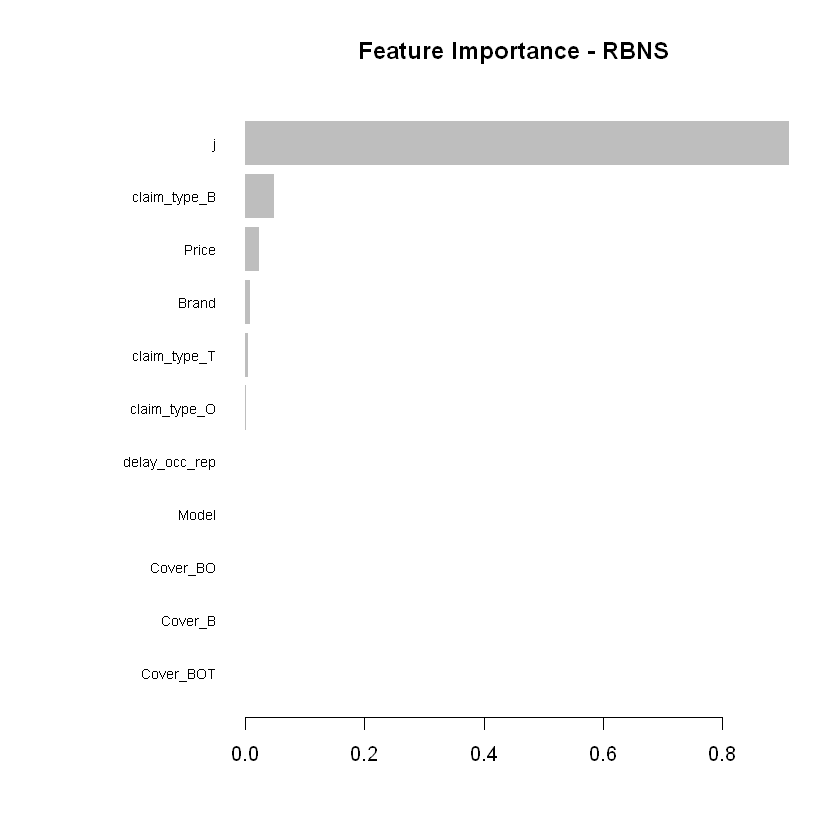

In [21]:
#default feature importance by gain
featImp_RBNS <- xgb.importance(xgb_RBNS_Fit, feature_names = colnames(xgb.RBNS_DMat.train))
xgb.plot.importance(featImp_RBNS, main="Feature Importance - RBNS")

In [24]:
# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_RBNS_Fit, X_train = as.matrix(df.RBNS_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.RBNS_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = nrow(df.RBNS_train)/10000)

ERROR: Error in shap.values(xgb_model = xgb_RBNS_Fit, X_train = as.matrix(df.RBNS_train)): could not find function "shap.values"


In [ ]:

fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)

In [25]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/nrow(shap_long),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  

ERROR: Error in shap.prep.stack.data(shap_contrib = shap_values$shap_score, data_percent = 10000/nrow(shap_long), : could not find function "shap.prep.stack.data"


In [22]:
dt_All_RBNS [, date_occur_YYYYMM := as.character(year(date_occur) + month(date_occur)/100 )]

dt_RBNS_summary <- dt_All_RBNS[rowList_RBNS$test,.(preds = sum(preds_full), target = sum(target)), keyby = date_occur_YYYYMM]


     

In [28]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_occur_YYYYMM = "Total"), dt_RBNS_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_RBNS_summary <- rbind(dt_RBNS_summary, sumrow, fill = TRUE)

dt_RBNS_summary[, ':='(Diff = (preds - target),
                       Diff_pcnt =  scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_RBNS_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_occur_YYYYMM,preds,target,Diff,Diff_pcnt
2016.04,"1,066",911,155,17.1%
2016.05,"5,147","5,188",-41,-0.8%
2016.06,"12,275","14,257","-1,982",-13.9%
2016.07,"56,097","53,815","2,282",4.2%
2016.08,"326,004","326,631",-627,-0.2%
2016.09,"618,081","622,179","-4,098",-0.7%
Total,"1,018,670","1,022,981","-4,311",-0.4%
Total,"2,037,341","2,045,962","-8,621",-0.4%


In [45]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

# aggregate the data ... does this lead to loss of variance and accuracy?
dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_F <- dt_All_IBNR[, .(exposure = sum(exposure),
                                   target_cost = sum(target),
                                   target_count = sum(target>0)),
                               by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_F <- dt_All_IBNR_F[exposure>0]


# setup train and test rows
rowList_IBNR_F <- list(train=dt_All_IBNR_F[, which(flgTrain==1)],
                     test=dt_All_IBNR_F[, which(flgTrain==0)],
                     all = dt_All_IBNR_F[, which(flgTrain!=2)])

# setup data for xgboost
IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_F[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_F_train <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$train,] )
df.IBNR_F_test <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$test,] )
df.IBNR_F_all <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$all,] )

xgb.IBNR_F_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_F_train),
                              weight = dt_All_IBNR_F[rowList_IBNR_F$train, exposure],
                              label = dt_All_IBNR_F[rowList_IBNR_F$train, target_count])

xgb.IBNR_F_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_F_test),
                             weight = dt_All_IBNR_F[rowList_IBNR_F$test, exposure],
                             label = dt_All_IBNR_F[rowList_IBNR_F$test, target_count])

xgb.IBNR_F_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_F_all),
                            weight = dt_All_IBNR_F[rowList_IBNR_F$all, exposure],
                            label = dt_All_IBNR_F[rowList_IBNR_F$all, target_count])

#weight = dt_All_IBNR_F[rowList_IBNR_F$train, exposure]: The exposure column is used as 
#weights for the XGBoost model. This ensures that claims occurring in policies with
#higher exposure contribute more to the model.

#label = dt_All_IBNR_F[rowList_IBNR_F$train, target_count]: The target count
#(number of claims that occurred) is the label (target variable) for the training data.

In [38]:
head(dt_All_IBNR_F)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost,target_count
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,1,B,1,3,913,16801,2016.01,1,25.16,0,0
1,1,B,2,3,837,16801,2016.01,1,18.50,0,0
1,1,B,3,3,457,16801,2016.01,1,10.36,0,0
1,1,B,4,3,229,16801,2016.01,1,7.40,0,0
1,1,B,1,2,794,16801,2016.01,1,18.50,0,0
1,1,B,1,1,690,16801,2016.01,1,5.92,0,0


In [41]:
head(df.IBNR_F_train)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,3,913,16801,1,0,0
1,1,2,3,837,16801,1,0,0
1,1,3,3,457,16801,1,0,0
1,1,4,3,229,16801,1,0,0
1,1,1,2,794,16801,1,0,0
1,1,1,1,690,16801,1,0,0


In [42]:
head(df.IBNR_F_test)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,3,913,16801,1,0,0
1,1,2,3,837,16801,1,0,0
1,1,3,3,457,16801,1,0,0
1,1,4,3,229,16801,1,0,0
1,1,1,2,794,16801,1,0,0
1,1,1,1,690,16801,1,0,0


In [44]:
head(df.IBNR_F_all)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,3,913,16801,1,0,0
1,1,2,3,837,16801,1,0,0
1,1,3,3,457,16801,1,0,0
1,1,4,3,229,16801,1,0,0
1,1,1,2,794,16801,1,0,0
1,1,1,1,690,16801,1,0,0


In [43]:
 #write.csv(dt_All_IBNR_F, "dt_ALL_IBNR_F.csv", row.names = FALSE)

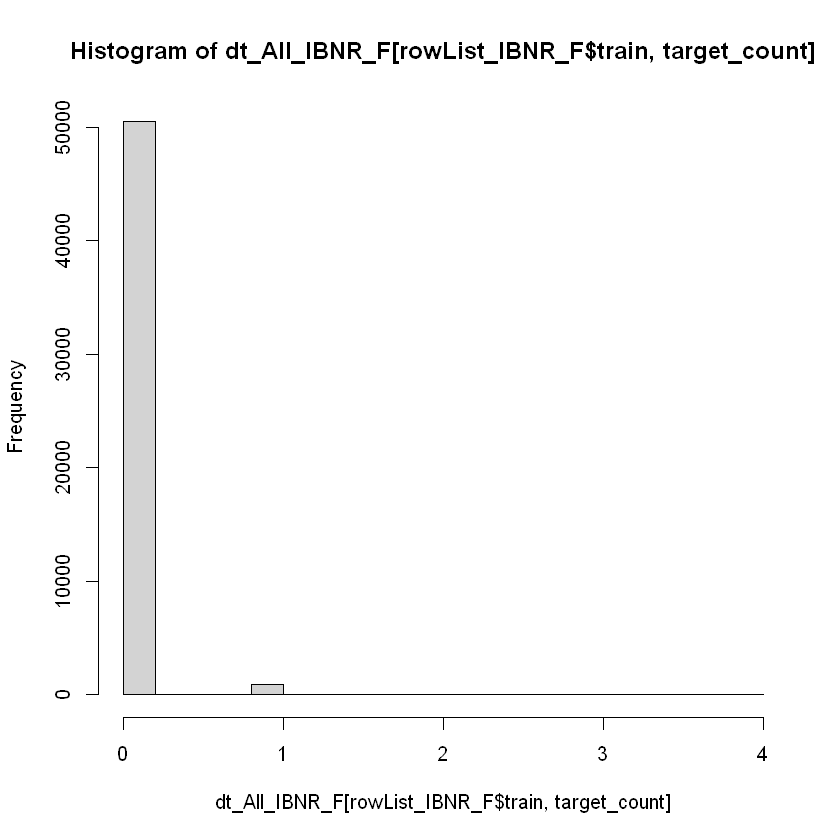

In [29]:

hist(dt_All_IBNR_F[rowList_IBNR_F$train, target_count])

In [46]:
param <- list(
  objective = "count:poisson",#Since you are predicting counts (like the number of claims), you use the Poisson distribution
  max_depth = 2L,           # tree-depth to avoid overfitting.
  subsample = 0.7,          # randomly sample rows before fitting each tree. the model will randomly sample 70% of the data and train on it.
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree.  80% of the features are randomly selected.
  min.child.weight = 10,    # minimum weight per leaf. each leaf must contain at least 10 observations before it can split further.
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_F_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_F_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
)


[1]	train-poisson-nloglik:0.615983+0.000516	test-poisson-nloglik:0.615994+0.001036 
Multiple eval metrics are present. Will use test_poisson_nloglik for early stopping.
Will train until test_poisson_nloglik hasn't improved in 50 rounds.

[51]	train-poisson-nloglik:0.169375+0.002012	test-poisson-nloglik:0.169430+0.005815 
[101]	train-poisson-nloglik:0.137262+0.002201	test-poisson-nloglik:0.137737+0.007821 
[151]	train-poisson-nloglik:0.132682+0.002179	test-poisson-nloglik:0.134066+0.008458 
[201]	train-poisson-nloglik:0.130792+0.002139	test-poisson-nloglik:0.133186+0.008710 
[251]	train-poisson-nloglik:0.129587+0.002116	test-poisson-nloglik:0.132927+0.008899 
[301]	train-poisson-nloglik:0.128581+0.002063	test-poisson-nloglik:0.133057+0.008991 
Stopping. Best iteration:
[267]	train-poisson-nloglik:0.129243+0.002140	test-poisson-nloglik:0.132899+0.008906



In [39]:
head(xgb_IBNR_F_CV)

$call
xgb.cv(params = param, data = xgb.IBNR_F_DMat.train, nrounds = 2000, 
    nfold = 5, prediction = TRUE, print_every_n = 50L, early_stopping_rounds = 50L)

$params
$params$objective
[1] "count:poisson"

$params$max_depth
[1] 2

$params$subsample
[1] 0.7

$params$colsample_bytree
[1] 0.8

$params$min_child_weight
[1] 10

$params$eta
[1] 0.1

$params$silent
[1] 1


$callbacks
$callbacks$cb.print.evaluation
function (env = parent.frame()) 
{
    if (length(env$bst_evaluation) == 0 || period == 0 || NVL(env$rank, 
        0) != 0) 
        return()
    i <- env$iteration
    if ((i - 1)%%period == 0 || i == env$begin_iteration || i == 
        env$end_iteration) {
        stdev <- if (showsd) 
            env$bst_evaluation_err
        else NULL
        msg <- .format_eval_string(i, env$bst_evaluation, stdev)
        cat(msg, "\n")
    }
}
<bytecode: 0x00000000313832f0>
<environment: 0x000000000e143398>
attr(,"call")
cb.print.evaluation(period = print_every_n, showsd = showsd)
attr(,"

In [31]:
 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_F := xgb_IBNR_F_CV$pred]
 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_Nos := exposure * preds_oof_IBNR_F]

In [50]:
dt_new_IBNR_F <- dt_All_IBNR_F

In [51]:
head(dt_new_IBNR_F)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost,target_count
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,1,B,1,3,913,16801,2016.01,1,25.16,0,0
1,1,B,2,3,837,16801,2016.01,1,18.50,0,0
1,1,B,3,3,457,16801,2016.01,1,10.36,0,0
1,1,B,4,3,229,16801,2016.01,1,7.40,0,0
1,1,B,1,2,794,16801,2016.01,1,18.50,0,0
1,1,B,1,1,690,16801,2016.01,1,5.92,0,0


In [35]:
head(dt_All_IBNR_F)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost,target_count,preds_oof_IBNR_F,preds_oof_IBNR_Nos,preds_full_IBNR_Nos
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,B,1,3,913,16801,2016.01,1,25.16,0,0,0.019692523,0.49546389,0.013586782
1,1,B,2,3,837,16801,2016.01,1,18.50,0,0,0.006619859,0.12246740,0.014210730
1,1,B,3,3,457,16801,2016.01,1,10.36,0,0,0.005609045,0.05810970,0.005577163
1,1,B,4,3,229,16801,2016.01,1,7.40,0,0,0.002388991,0.01767853,0.005105766
1,1,B,1,2,794,16801,2016.01,1,18.50,0,0,0.020315476,0.37583630,0.012678672
1,1,B,1,1,690,16801,2016.01,1,5.92,0,0,0.005146052,0.03046463,0.003915477


In [49]:
 write.csv(dt_All_IBNR_F, "dt_ALL_IBNR_F1.csv", row.names = FALSE)

In [54]:
xgb_IBNR_F_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_F_DMat.train,
   nrounds                = xgb_IBNR_F_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )
 
 dt_All_IBNR_F[rowList_IBNR_F$all, preds_full_IBNR_Nos := predict(xgb_IBNR_F_Fit,xgb.IBNR_F_DMat.all)]

     

[1]	train-poisson-nloglik:0.616065	test-poisson-nloglik:0.606831 
[51]	train-poisson-nloglik:0.169623	test-poisson-nloglik:0.129184 
[101]	train-poisson-nloglik:0.137296	test-poisson-nloglik:0.088775 
[151]	train-poisson-nloglik:0.132780	test-poisson-nloglik:0.084293 
[201]	train-poisson-nloglik:0.131201	test-poisson-nloglik:0.083150 
[251]	train-poisson-nloglik:0.130244	test-poisson-nloglik:0.083090 
[267]	train-poisson-nloglik:0.129909	test-poisson-nloglik:0.083045 


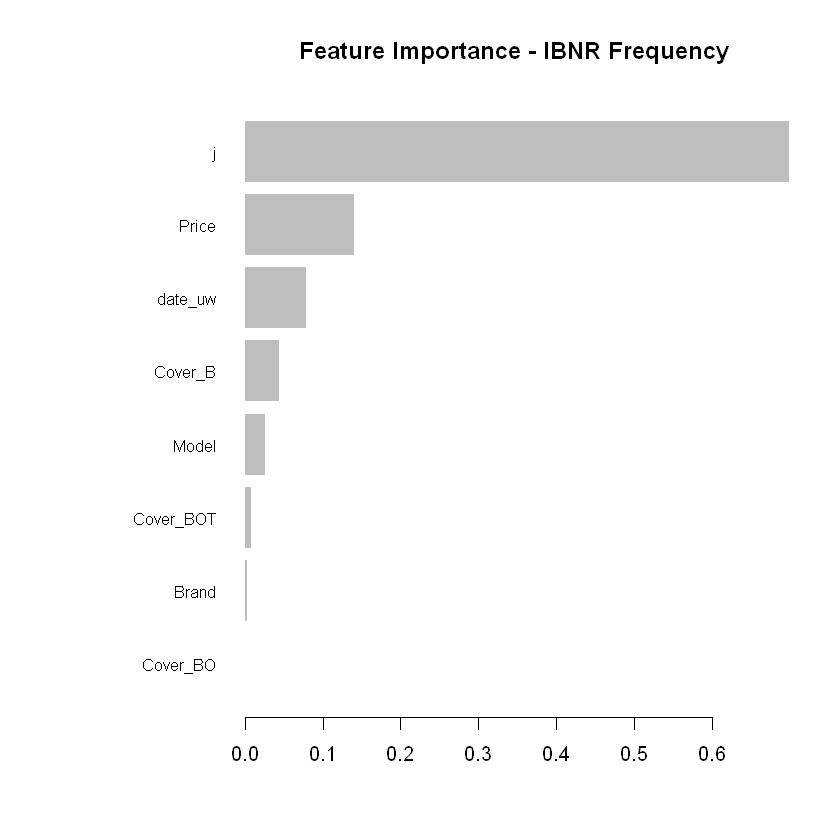

In [55]:
featImp_IBNR_F <- xgb.importance(xgb_IBNR_F_Fit, feature_names = colnames(xgb.IBNR_F_DMat.train))
xgb.plot.importance(featImp_IBNR_F, main="Feature Importance - IBNR Frequency")


In [56]:
dt_All_IBNR_F_summary <- dt_All_IBNR_F[rowList_IBNR_F$test,.(preds = sum(preds_full_IBNR_Nos), target = sum(target_count)), keyby = date_pol_start_YYYYMM]

In [57]:
head(dt_All_IBNR_F_summary)

date_pol_start_YYYYMM,preds,target
<chr>,<dbl>,<int>
2016.01,211.5896,168
2016.02,186.2074,176
2016.03,187.5753,160
2016.04,183.8425,164
2016.05,177.0872,195
2016.06,166.5845,179


In [58]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_F_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_F_summary <- rbind(dt_All_IBNR_F_summary, sumrow, fill = TRUE)

dt_All_IBNR_F_summary[, ':='(Diff = (preds - target),
                        Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_F_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,212,168,44,25.9%
2016.02,186,176,10,5.8%
2016.03,188,160,28,17.2%
2016.04,184,164,20,12.1%
2016.05,177,195,-18,-9.2%
2016.06,167,179,-12,-6.9%
2016.07,113,170,-57,-33.3%
2016.08,85,162,-77,-47.4%
2016.09,77,59,18,30.0%
Total,"1,388","1,433",-45,-3.1%


In [68]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_S <- dt_All_IBNR[, .(exposure = sum(target>0),
                                 target_cost = sum(target)),
                            by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_S <- dt_All_IBNR_S[exposure>0]

# setup train and test rows
rowList_IBNR_S <- list(train=dt_All_IBNR_S[, which(flgTrain==2)],
                     test=dt_All_IBNR_S[, which(flgTrain==0)],
                     all = dt_All_IBNR_S[, which(flgTrain!=1)])

# setup data for xgboost

IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_S[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_S_train <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$train,] )
df.IBNR_S_test <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$test,] )
df.IBNR_S_all <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$all,] )



xgb.IBNR_S_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_S_train),
                              weight = dt_All_IBNR_S[rowList_IBNR_S$train, exposure],
                              label = dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

xgb.IBNR_S_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_S_test),
                             weight = dt_All_IBNR_S[rowList_IBNR_S$test, exposure],
                             label = dt_All_IBNR_S[rowList_IBNR_S$test, target_cost])

xgb.IBNR_S_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_S_all),
                            weight = dt_All_IBNR_S[rowList_IBNR_S$all, exposure],
                            label = dt_All_IBNR_S[rowList_IBNR_S$all, target_cost])

In [69]:
head(dt_All_IBNR)

clm_number,pol_number,j,k,exposure,date_pol_start,date_occur,date_report,date_pay,Cover,...,Price,target,flgTrain,Count,delay_uw_occ,delay_occ_rep,delay_rep_pay,delay_uw_val,date_uw,date_pol_start_YYYYMM
<chr>,<chr>,<int>,<int>,<dbl>,<dttm>,<dttm>,<dttm>,<dttm>,<fct>,...,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NA,201601010002,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01
NA,201601010003,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01
NA,201601010004,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01
NA,201601010005,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01
NA,201601010006,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01
NA,201601010007,1,1,0.74,2016-01-01,2199-12-31 23:59:59,2199-12-31 23:59:59,2199-12-31 23:59:59,B,...,913,0,1,2067788,-1,-1,-1,270,16801,2016.01


In [70]:
head(dt_All_IBNR_S)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>
1,1,BOT,1,3,913,16809,2016.01,1,1,1
1,1,BO,3,1,345,16815,2016.01,1,1,1
1,1,BO,2,0,550,16816,2016.01,1,1,1
1,1,BO,4,2,199,16817,2016.01,1,1,1
1,1,BOT,1,3,913,16818,2016.01,1,1,1
1,1,BO,2,3,837,16819,2016.01,1,1,1


In [71]:
head(rowList_IBNR_S)

$train
   [1] 2303 2304 2305 2306 2307 2308 2309 2310 2311 2312 2313 2314 2315 2316
  [15] 2317 2318 2319 2320 2321 2322 2323 2324 2325 2326 2327 2328 2329 2330
  [29] 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341 2342 2343 2344
  [43] 2345 2346 2347 2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358
  [57] 2359 2360 2361 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372
  [71] 2373 2374 2375 2376 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386
  [85] 2387 2388 2389 2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400
  [99] 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414
 [113] 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428
 [127] 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442
 [141] 2443 2444 2445 2446 2447 2448 2449 2450 2451 2452 2453 2454 2455 2456
 [155] 2457 2458 2459 2460 2461 2462 2463 2464 2465 2466 2467 2468 2469 2470
 [169] 2471 2472 2473 2474 2475 2476 2477 2478 2479 2480 2481 2482 2483 2484
 [183] 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495 2496 2497 2498
 [197] 2499 2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512
 [211] 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526
 [225] 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540
 [239] 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554
 [253] 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568
 [267] 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582
 [281] 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596
 [295] 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610
 [309] 2611 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624
 [323] 2625 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638
 [337] 2639 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652
 [351] 2653 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666
 [365] 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678 2679 2680
 [379] 2681 2682 2683 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694
 [393] 2695 2696 2697 2698 2699 2700 2701 2702 2703 2704 2705 2706 2707 2708
 [407] 2709 2710 2711 2712 2713 2714 2715 2716 2717 2718 2719 2720 2721 2722
 [421] 2723 2724 2725 2726 2727 2728 2729 2730 2731 2732 2733 2734 2735 2736
 [435] 2737 2738 2739 2740 2741 2742 2743 2744 2745 2746 2747 2748 2749 2750
 [449] 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760 2761 2762 2763 2764
 [463] 2765 2766 2767 2768 2769 2770 2771 2772 2773 2774 2775 2776 2777 2778
 [477] 2779 2780 2781 2782 2783 2784 2785 2786 2787 2788 2789 2790 2791 2792
 [491] 2793 2794 2795 2796 2797 2798 2799 2800 2801 2802 2803 2804 2805 2806
 [505] 2807 2808 2809 2810 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820
 [519] 2821 2822 2823 2824 2825 2826 2827 2828 2829 2830 2831 2832 2833 2834
 [533] 2835 2836 2837 2838 2839 2840 2841 2842 2843 2844 2845 2846 2847 2848
 [547] 2849 2850 2851 2852 2853 2854 2855 2856 2857 2858 2859 2860 2861 2862
 [561] 2863 2864 2865 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876
 [575] 2877 2878 2879 2880 2881 2882 2883 2884 2885 2886 2887 2888 2889 2890
 [589] 2891 2892 2893 2894 2895 2896 2897 2898 2899 2900 2901 2902 2903 2904
 [603] 2905 2906 2907 2908 2909 2910 2911 2912 2913 2914 2915 2916 2917 2918
 [617] 2919 2920 2921 2922 2923 2924 2925 2926 2927 2928 2929 2930 2931 2932
 [631] 2933 2934 2935 2936 2937 2938 2939 2940 2941 2942 2943 2944 2945 2946
 [645] 2947 2948 2949 2950 2951 2952 2953 2954 2955 2956 2957 2958 2959 2960
 [659] 2961 2962 2963 2964 2965 2966 2967 2968 2969 2970 2971 2972 2973 2974
 [673] 2975 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 2986 2987 2988
 [687] 2989 2990 2991 2992 2993 2994 2995 2996 2997 2998 2999 3000 3001 3002
 [701] 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013 3014 3015 3016
 [715] 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028

In [62]:
head(df.IBNR_S_train)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,1,2,3,837,16805,0,0,1
8,1,1,2,794,16809,0,0,1
8,1,1,3,913,16814,0,1,0
8,1,3,3,457,16822,0,1,0
8,1,3,3,457,16809,0,1,0
8,1,3,3,457,16824,0,0,1


In [63]:
head(df.IBNR_S_test)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,3,837,16805,0,0,1
1,1,4,3,229,16807,0,1,0
1,1,2,1,633,16808,1,0,0
1,1,2,0,550,16811,0,1,0
1,1,2,1,633,16813,0,0,1
1,1,1,3,913,16816,0,0,1


In [64]:
head(df.IBNR_S_all)

j,k,Brand,Model,Price,date_uw,Cover_B,Cover_BO,Cover_BOT
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,3,837,16805,0,0,1
1,1,4,3,229,16807,0,1,0
1,1,2,1,633,16808,1,0,0
1,1,2,0,550,16811,0,1,0
1,1,2,1,633,16813,0,0,1
1,1,1,3,913,16816,0,0,1


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0   125.5   255.0   353.9   486.5  2011.0 

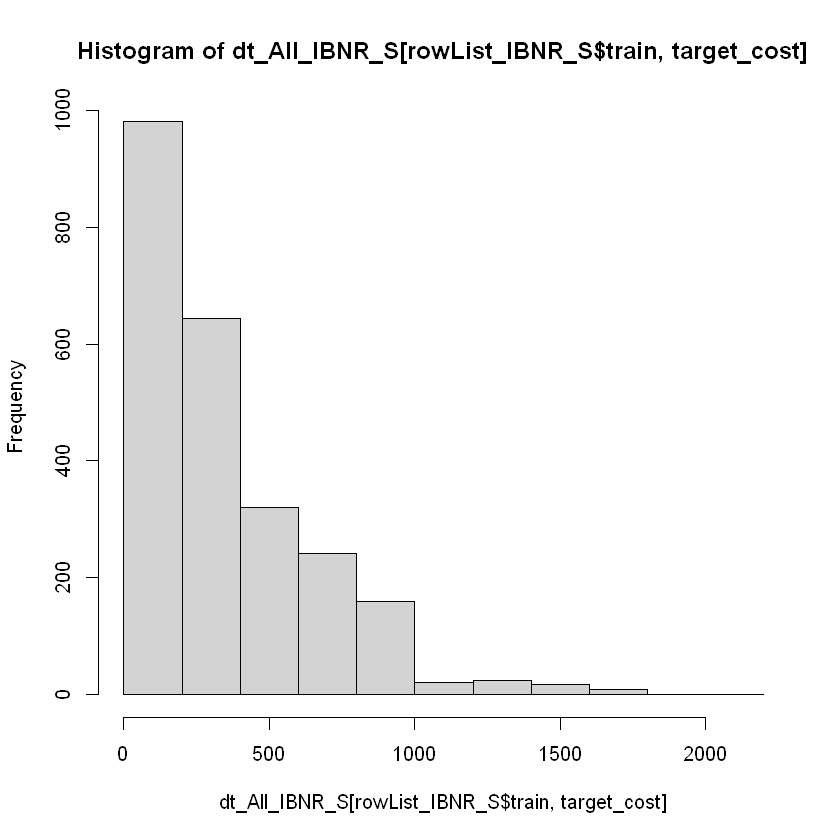

In [38]:
summary(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])
hist(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

In [72]:
param <- list(
  objective = "reg:gamma",
  max_depth = 2L,           # tree-depth
  subsample = 0.7,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree
  min.child.weight = 10,    # minimum weight per leaf
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)

# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_S_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_S_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
) 
     

[1]	train-gamma-nloglik:135.111800+2.147737	test-gamma-nloglik:134.960497+8.878000 
Multiple eval metrics are present. Will use test_gamma_nloglik for early stopping.
Will train until test_gamma_nloglik hasn't improved in 50 rounds.

[51]	train-gamma-nloglik:7.117216+0.023912	test-gamma-nloglik:7.122154+0.130271 
[101]	train-gamma-nloglik:6.815663+0.017024	test-gamma-nloglik:6.825915+0.070990 
[151]	train-gamma-nloglik:6.808179+0.017122	test-gamma-nloglik:6.826168+0.070992 
Stopping. Best iteration:
[121]	train-gamma-nloglik:6.811926+0.017127	test-gamma-nloglik:6.825021+0.070641



In [73]:
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_S := xgb_IBNR_S_CV$pred]
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_Cost := exposure * preds_oof_IBNR_S]

In [74]:
head(dt_All_IBNR_S)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost,preds_oof_IBNR_S,preds_oof_IBNR_Cost
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,BOT,1,3,913,16809,2016.01,1,1,1,NA,NA
1,1,BO,3,1,345,16815,2016.01,1,1,1,NA,NA
1,1,BO,2,0,550,16816,2016.01,1,1,1,NA,NA
1,1,BO,4,2,199,16817,2016.01,1,1,1,NA,NA
1,1,BOT,1,3,913,16818,2016.01,1,1,1,NA,NA
1,1,BO,2,3,837,16819,2016.01,1,1,1,NA,NA


In [79]:

xgb_IBNR_S_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_S_DMat.train,
   nrounds                = xgb_IBNR_S_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )

     

[1]	train-gamma-nloglik:1.110040	test-gamma-nloglik:1.105260 
[51]	train-gamma-nloglik:5.196263	test-gamma-nloglik:5.193286 
[101]	train-gamma-nloglik:5.663059	test-gamma-nloglik:5.647153 
[121]	train-gamma-nloglik:5.642347	test-gamma-nloglik:5.595071 


In [80]:
dt_All_IBNR_S[rowList_IBNR_S$all, preds_full_IBNR_Cost := predict(xgb_IBNR_S_Fit,xgb.IBNR_S_DMat.all)]
     

In [81]:
head(dt_All_IBNR_S)

j,k,Cover,Brand,Model,Price,date_uw,date_pol_start_YYYYMM,flgTrain,exposure,target_cost,preds_oof_IBNR_S,preds_oof_IBNR_Cost,preds_full_IBNR_Cost
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,BOT,1,3,913,16809,2016.01,1,1,1,NA,NA,NA
1,1,BO,3,1,345,16815,2016.01,1,1,1,NA,NA,NA
1,1,BO,2,0,550,16816,2016.01,1,1,1,NA,NA,NA
1,1,BO,4,2,199,16817,2016.01,1,1,1,NA,NA,NA
1,1,BOT,1,3,913,16818,2016.01,1,1,1,NA,NA,NA
1,1,BO,2,3,837,16819,2016.01,1,1,1,NA,NA,NA


In [83]:
 write.csv(dt_All_IBNR_S, "dt_ALL_IBNR_S2.csv", row.names = FALSE)

In [84]:
dt_All_IBNR_S_summary <- dt_All_IBNR_S[rowList_IBNR_S$test,.(preds = sum(preds_full_IBNR_Cost), target = sum(target_cost)), keyby = date_pol_start_YYYYMM]
     

In [86]:
head(dt_All_IBNR_S_summary)

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
<chr>,<dbl>,<dbl>,<dbl>,<chr>
2016.01,57902.16,52782,5120.15592,9.7%
2016.02,55310.87,55615,-304.13121,-0.5%
2016.03,52808.27,47200,5608.26840,11.9%
2016.04,55002.98,56975,-1972.02096,-3.5%
2016.05,66641.82,64833,1808.81733,2.8%
2016.06,52906.18,52989,-82.81675,-0.2%


In [87]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_S_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_S_summary <- rbind(dt_All_IBNR_S_summary, sumrow, fill = TRUE)

dt_All_IBNR_S_summary[, ':='(Diff = (preds - target),
                     Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_S_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,"57,902","52,782","5,120",9.7%
2016.02,"55,311","55,615",-304,-0.5%
2016.03,"52,808","47,200","5,608",11.9%
2016.04,"55,003","56,975","-1,972",-3.5%
2016.05,"66,642","64,833","1,809",2.8%
2016.06,"52,906","52,989",-83,-0.2%
2016.07,"49,497","50,276",-779,-1.5%
2016.08,"49,734","53,502","-3,768",-7.0%
2016.09,"18,100","18,989",-889,-4.7%
Total,"457,904","453,161","4,743",1.0%


In [88]:
summary_table <- data.table(
  Reserve = c("RBNS", "IBNR", "TOTAL"),
  Prediction = c(dt_All_RBNS[rowList_RBNS$test, sum(preds_full)],
                 dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)],
                 dt_All_RBNS[rowList_RBNS$test, sum(preds_full)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)]),
  Ground_Truth = c(dt_All_RBNS[rowList_RBNS$test, sum(target)],
                   dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)],
                   dt_All_RBNS[rowList_RBNS$test, sum(target)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)])
)

summary_table[, ':='(
  Diff = (Prediction - Ground_Truth),
  Diff_pcnt =  scales::percent((Prediction - Ground_Truth) / Ground_Truth, accuracy = 0.1)
)]


kable(
  summary_table,
  "html",
  digits = c(0, 0, 0, 0, 1),
  format.args = list(big.mark = ",",
                     scientific = FALSE)
) %>%
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

Reserve,Prediction,Ground_Truth,Diff,Diff_pcnt
RBNS,"1,018,670","1,022,981","-4,311",-0.4%
IBNR,"457,904","453,161","4,743",1.0%
TOTAL,"1,476,574","1,476,142",432,0.0%
